# **Chapter 6: Synchronization Tools – Practice Exercise Solutions**

## **6.1 Clock Interrupts and Disabling Interrupts**

**Question:**  
In Section 6.4, we mentioned that disabling interrupts frequently can affect the system’s clock. Explain why this can occur and how such effects can be minimized.

**Answer:**  
The system clock is updated at every **clock interrupt**. If interrupts are disabled—especially for extended periods—the system clock may lose accurate timekeeping because it misses these updates. Additionally, the scheduler relies on clock ticks to measure **time quanta** assigned to processes. At each clock interrupt, the scheduler checks if the currently running process’s time quantum has expired. If interrupts are disabled, scheduling accuracy degrades.

**Minimization:**  
Disable interrupts only for **very short periods**, ensuring the clock interrupt is not delayed significantly. Use higher-priority synchronization mechanisms (e.g., atomic instructions or spinlocks in multiprocessor systems) where possible instead of relying solely on interrupt disabling.


## **6.5 Binary Semaphore for Mutual Exclusion**

**Question:**  
Illustrate how a binary semaphore can be used to implement mutual exclusion among *n* processes.

**Answer:**  
Shared binary semaphore `mutex` initialized to 1.  
Each process `P_i` executes:

```c
do {
    wait(mutex);
    // Critical Section
    signal(mutex);
    // Remainder Section
} while (true);
```

**Explanation:**  
Only one process can pass `wait(mutex)` at a time because the semaphore acts as a lock. After exiting the critical section, `signal(mutex)` releases the lock.



## **Exercise 6.16**
**Question:**  
One approach for using compare and swap() for implementing a spinlock is as follows:
```
void lock_spinlock(int *lock) {
while (compare_and_swap(lock, 0, 1) != 0)
; /* spin */
}
```
A suggested alternative approach is to use the “compare and compare-and-swap” idiom, which checks the status of the lock before invoking the compare and swap() operation. (The rationale behind this approach is to invoke compare and swap() only if the lock is currently available.) This strategy is shown below:
```
void lock_spinlock(int *lock) {
while (true) {
if (*lock == 0) {
/* lock appears to be available */
if (!compare_and_swap(lock, 0, 1))
break;
}
}
}
```
Does this “compare and compare-and-swap” idiom work appropriately for implementing spinlocks? If so, explain. If not, illustrate how the integrity of the lock is compromised.

**Answer:**  
No, the "compare and compare-and-swap" idiom **does not work appropriately** for implementing spinlocks in a concurrent environment. It compromises the integrity of the lock by allowing **multiple threads to potentially acquire the lock simultaneously**, violating mutual exclusion.

**How integrity is compromised:**  
Between the check `if (*lock == 0)` and the subsequent `compare_and_swap(lock, 0, 1)`, another thread can modify `*lock`. For example:
1. Thread A checks `*lock`, finds it 0 (available).
2. Before Thread A executes its CAS, Thread B also checks `*lock`, finds it 0, and successfully performs a CAS, setting `*lock` to 1 and acquiring the lock.
3. Thread A now proceeds to its CAS: it expects `*lock` to be 0 (but it's now 1), so the CAS fails (returns a non-zero value). However, because the code uses `if (!compare_and_swap(...))` (i.e., breaks only if CAS returns 0/false), the CAS failure means it does **not** break out of the loop. Instead, it continues spinning.
4. Thread B releases the lock (sets `*lock` back to 0).
5. Thread A, still in its loop, will again see `*lock == 0` in the next iteration, and may now successfully CAS, acquiring the lock.
6. Meanwhile, another Thread C could also see the lock as 0 and compete.


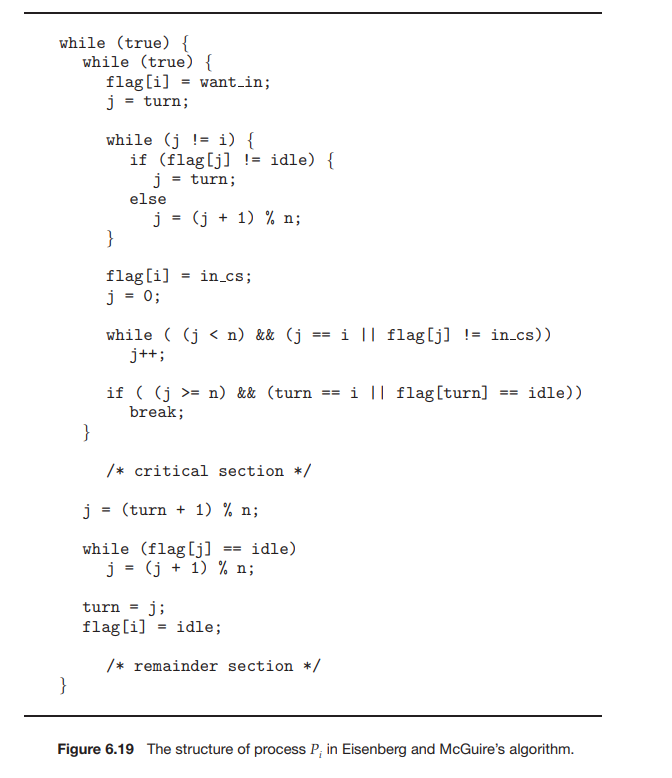


## **Exercise 6.19**
**Question:**  
The first known correct software solution to the critical-section problem for n processes with a lower bound on waiting of n − 1 turns was presented by Eisenberg and McGuire. The processes share the following variables:
```
enum pstate {idle, want_in, in_cs};
pstate flag[n];
int turn;
```
All the elements of flag are initially idle. The initial value of turn is immaterial (between 0 and n-1). The structure of process Pi is shown in Figure 6.19. Prove that the algorithm satisfies all three requirements for the critical-section problem.




**Answer:**  
**Eisenberg and McGuire's Algorithm Proof:**  
The algorithm uses a rotating priority mechanism.

**1. Mutual Exclusion:**  
- A process Pi enters the critical section only when it has set `flag[i] = in_cs` and verified that no other process is in `in_cs` state (`while ((j < n) && (j == i || flag[j] != in_cs))` ensures all other `flag[j]` are not `in_cs`). Also, it ensures that either it is its turn (`turn == i`) or the current `turn` process is idle. This guarantees that only one process can be in the `in_cs` state at a time.

**2. Progress:**  
- If no process is in CS and some processes want to enter, the `turn` variable and the scanning loop ensure that one will eventually pass the conditions. The algorithm avoids deadlock because processes waiting will repeatedly scan; the `turn` variable rotates, giving each process a chance. A process unable to enter will eventually see `turn == i` or `flag[turn] == idle` and break into CS.

**3. Bounded Waiting:**  
- The waiting bound is n-1 turns. After a process Pi exits the CS, it updates `turn` to the next process with `flag[j] != idle` in cyclic order. This ensures that processes wanting to enter are served in a round-robin fashion relative to the `turn` pointer. A process Pi will wait while at most n-1 other processes enter the CS before it, because `turn` will eventually point to Pi after serving others in the waiting set.

Thus, the algorithm satisfies mutual exclusion, progress, and bounded waiting for n processes.
